In [1]:
import os
import pandas as pd
import numpy as np
import torch 
from multiprocessing import cpu_count
from langdetect import detect, DetectorFactory
import seaborn as sns
import matplotlib.pyplot as plt

from transformers import M2M100ForConditionalGeneration, M2M100Tokenizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import AutoModelForSequenceClassification, AutoTokenizer

from tqdm.auto import tqdm



## 1 Load Data

In [2]:
df = pd.read_csv("../data/notes-00000.tsv", sep="\t")

C:\Users\jguo27\AppData\Local\Temp\ipykernel_17548\2127296574.py:1: DtypeWarning: Columns (0: believable, 1: harmful, 2: validationDifficulty) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/notes-00000.tsv", sep="\t")


### 1.1 Basic Checks

In [3]:
df = df.dropna(subset=["summary"])

In [4]:
df.shape

(2347608, 24)

In [5]:
df.columns

Index(['noteId', 'noteAuthorParticipantId', 'createdAtMillis', 'tweetId',
       'classification', 'believable', 'harmful', 'validationDifficulty',
       'misleadingOther', 'misleadingFactualError',
       'misleadingManipulatedMedia', 'misleadingOutdatedInformation',
       'misleadingMissingImportantContext', 'misleadingUnverifiedClaimAsFact',
       'misleadingSatire', 'notMisleadingOther',
       'notMisleadingFactuallyCorrect',
       'notMisleadingOutdatedButNotWhenWritten', 'notMisleadingClearlySatire',
       'notMisleadingPersonalOpinion', 'trustworthySources', 'summary',
       'isMediaNote', 'isCollaborativeNote'],
      dtype='str')

In [6]:
df = df[["noteId", "summary"]]

In [7]:
df.shape

(2347608, 2)

In [8]:
df.head()

,noteId,summary
0,1783179305159200982,The House failed to pass a border protection l...
1,1783181538789605871,The United States has 50 States https://da...
2,1783182562279494134,TikTok only mentions “ban” and chooses to igno...
3,1883711635770196070,This could be considered a threat https://...
4,1537142913737428992,Forbes has a good rundown of the investigation...


In [9]:
df.shape

(2347608, 2)

### 1.2 Cuda Check

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

print(torch.__version__)
print(torch.cuda.is_available())

cuda
2.9.1+rocmsdk20260116
True


In [7]:
OUTPUT_DIR = "outputs"

os.makedirs(OUTPUT_DIR, exist_ok=True)

In [ ]:
OUT_PATH = "outputs/notes.parquet"
df.to_parquet(OUT_PATH, engine="pyarrow", index=False)

## 2 Translate Summary

### 2.1 Detect Original Language using "LangDetect:

By testing apply `facebook/m2m100_418M` without specifying input language doesn't generate accurate translation.

In [2]:
DetectorFactory.seed = 0
MAX_CHARS = 300


def detect_lang(text, default="en") -> str:
    if text is None:
        return default
    if not isinstance(text, str):
        text = str(text)

    text = text.strip()
    if not text:
        return default

    text = text[:MAX_CHARS]
    try:
        return detect(text)
    except Exception:
        return default


def process_parquet_serial(
    in_path: str,
    out_path: str,
    text_col: str = "summary",
    chunksize: int = 50_000,
):
    os.makedirs(os.path.dirname(out_path), exist_ok=True)

    df = pd.read_parquet(in_path, engine="pyarrow")
    total_rows = len(df)

    out_chunks = []

    for start in tqdm(range(0, total_rows, chunksize), desc="chunks"):
        end = min(start + chunksize, total_rows)
        chunk = df.iloc[start:end].copy()

        if text_col not in chunk.columns:
            raise KeyError(f"Column '{text_col}' not found. Available: {list(chunk.columns)}")

        texts = chunk[text_col].tolist()

        langs = [detect_lang(t) for t in tqdm(texts, desc=f"rows {start}-{end}", leave=False)]
        chunk["lang"] = langs

        out_chunks.append(chunk)

    final_df = pd.concat(out_chunks, ignore_index=True)
    final_df.to_parquet(out_path, engine="pyarrow", index=False)
    print(f"saved to {out_path}")

In [3]:
IN_PATH = "outputs/notes.parquet"
OUT_PATH = "outputs/notes_lang.parquet"
TEXT_COL = "summary"
CHUNK = 50_000

if os.path.exists(OUT_PATH):
    df = pd.read_parquet(OUT_PATH, engine="pyarrow")
else:
    process_parquet_serial(
        in_path=IN_PATH,
        out_path=OUT_PATH,
        text_col=TEXT_COL,
        chunksize=CHUNK,
    )
    df   = pd.read_parquet(OUT_PATH, engine="pyarrow")

chunks: 100%|██████████| 47/47 [49:23<00:00, 63.05s/it]


saved to outputs/notes_lang.parquet


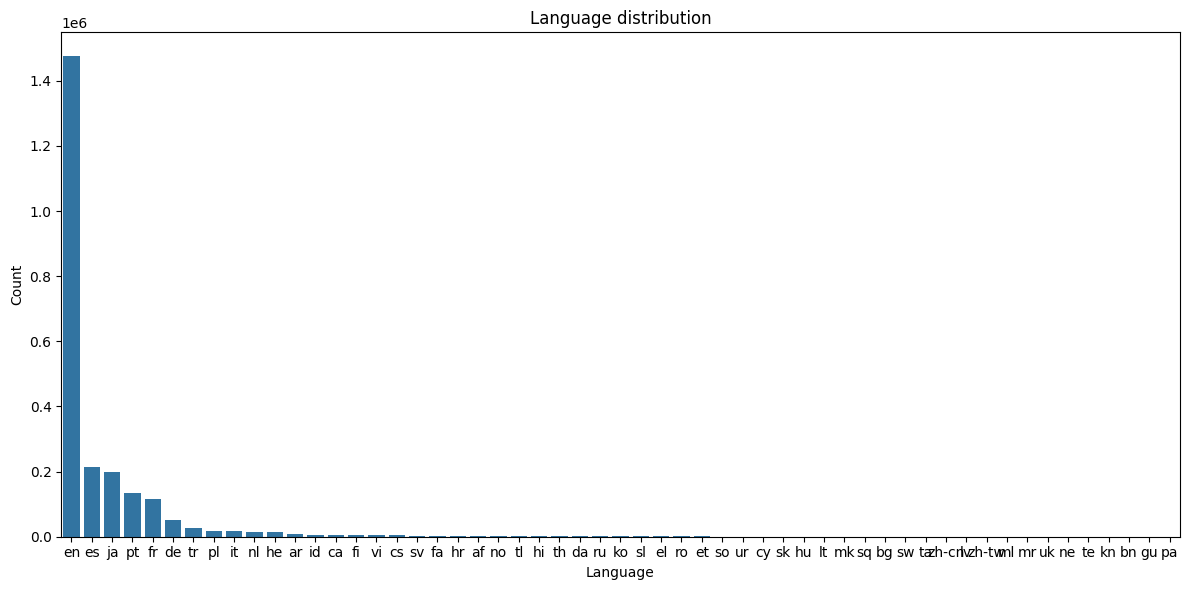

In [4]:
lang_counts = df["lang"].value_counts().reset_index()
lang_counts.columns = ["lang", "count"]

plt.figure(figsize=(12, 6))
sns.barplot(data=lang_counts, x="lang", y="count")
plt.title("Language distribution")
plt.xlabel("Language")
plt.ylabel("Count")
plt.xticks()
plt.tight_layout()
plt.show()

### 2.2 Translate using "facebook/m2m100_418M" model

In [8]:
MODEL_NAME = "facebook/m2m100_418M"

model = M2M100ForConditionalGeneration.from_pretrained(MODEL_NAME).to(device)
tokenizer = M2M100Tokenizer.from_pretrained(MODEL_NAME)


In [9]:
def translate_to_en(
    texts,
    langs,
    model,
    tokenizer,
    device,
    batch_size=8,
    max_length=256,
    translate_english=False,
):
    buckets = {}

    for idx, lang in enumerate(langs):
        lang = lang or "en"
        if (not translate_english) and lang == "en":
            continue
        buckets.setdefault(lang, []).append(idx)

    results = list(texts)

    model.eval()
    with torch.no_grad():
        for lang, idxs in buckets.items():
            try:
                tokenizer.get_lang_id(lang)
                tokenizer.src_lang = lang
            except Exception:
                tokenizer.src_lang = "en"

            for i in range(0, len(idxs), batch_size):
                batch_idxs = idxs[i : i + batch_size]
                batch_texts = [
                    texts[j] if texts[j] is not None else ""
                    for j in batch_idxs
                ]

                encoded = tokenizer(
                    batch_texts,
                    return_tensors="pt",
                    padding=True,
                    truncation=True,
                    max_length=max_length,
                )
                encoded = {k: v.to(device) for k, v in encoded.items()}

                generated = model.generate(
                    **encoded,
                    forced_bos_token_id=tokenizer.get_lang_id("en"),
                    max_new_tokens=128,
                    num_beams=1,
                )

                outs = tokenizer.batch_decode(
                    generated,
                    skip_special_tokens=True,
                )

                for j, out in zip(batch_idxs, outs):
                    results[j] = out

    return results


In [ ]:
def process_parquet_translate_chunked(
    in_path: str,
    out_path: str,
    text_col: str = "summary",
    lang_col: str = "lang",
    out_col: str = "summary_en",
    chunksize: int = 50_000,
    batch_size: int = 32,
    max_length: int = 256,
    translate_english: bool = False,
    model=None,
    tokenizer=None,
    device=None,
):
    os.makedirs(os.path.dirname(out_path), exist_ok=True)

    df = pd.read_parquet(in_path, engine="pyarrow")
    total_rows = len(df)

    out_chunks = []

    model.eval()
    with torch.no_grad():
        for start in tqdm(range(0, total_rows, chunksize), desc="parquet chunks"):
            end = min(start + chunksize, total_rows)
            chunk = df.iloc[start:end].copy()

            texts = chunk[text_col].tolist()
            langs = chunk[lang_col].tolist()

            chunk[out_col] = translate_to_en(
                texts=texts,
                langs=langs,
                model=model,
                tokenizer=tokenizer,
                device=device,
                batch_size=batch_size,
                max_length=max_length,
                translate_english=translate_english,
            )

            out_chunks.append(chunk)
            print(f"rows {start}-{end} done")

    final_df = pd.concat(out_chunks, ignore_index=True)
    final_df.to_parquet(out_path, engine="pyarrow", index=False)
    print(f"saved to {out_path}")


In [12]:
IN_PATH = "outputs/notes_lang.parquet"
OUT_PATH = "outputs/notes_lang_translate.parquet"
TEXT_COL = "summary"
CHUNK = 50_000

if os.path.exists(OUT_PATH):

    df = pd.read_parquet(OUT_PATH, engine="pyarrow")

else:
    process_parquet_translate_chunked(
        in_path=IN_PATH,
        out_path=OUT_PATH,
        text_col="summary",
        lang_col="lang",
        out_col="summary_en",
        chunksize=CHUNK,
        batch_size=32,
        max_length=256,
        translate_english=False,
        model=model,
        tokenizer=tokenizer,
        device=device,
    )
    df = pd.read_parquet(OUT_PATH, engine="pyarrow")


parquet chunks:   2%|▏         | 1/47 [28:28<21:49:31, 1708.07s/it]

rows 0-50000 done


parquet chunks:   4%|▍         | 2/47 [46:58<16:57:30, 1356.67s/it]

rows 50000-100000 done


parquet chunks:   6%|▋         | 3/47 [1:07:15<15:47:58, 1292.69s/it]

rows 100000-150000 done


parquet chunks:   9%|▊         | 4/47 [1:37:38<17:56:34, 1502.20s/it]

rows 150000-200000 done


parquet chunks:  11%|█         | 5/47 [2:15:16<20:42:21, 1774.81s/it]

rows 200000-250000 done


parquet chunks:  13%|█▎        | 6/47 [3:06:45<25:18:02, 2221.52s/it]

rows 250000-300000 done


parquet chunks:  15%|█▍        | 7/47 [3:54:24<26:59:57, 2429.93s/it]

rows 300000-350000 done


parquet chunks:  17%|█▋        | 8/47 [4:49:37<29:22:11, 2711.07s/it]

rows 350000-400000 done


parquet chunks:  19%|█▉        | 9/47 [5:37:33<29:09:34, 2762.49s/it]

rows 400000-450000 done


parquet chunks:  21%|██▏       | 10/47 [6:19:24<27:35:47, 2685.07s/it]

rows 450000-500000 done


parquet chunks:  23%|██▎       | 11/47 [7:05:27<27:05:17, 2708.82s/it]

rows 500000-550000 done


parquet chunks:  26%|██▌       | 12/47 [7:43:05<25:00:12, 2571.78s/it]

rows 550000-600000 done


parquet chunks:  28%|██▊       | 13/47 [8:18:28<23:00:10, 2435.61s/it]

rows 600000-650000 done


parquet chunks:  30%|██▉       | 14/47 [9:00:47<22:36:49, 2466.94s/it]

rows 650000-700000 done


parquet chunks:  32%|███▏      | 15/47 [9:36:36<21:04:39, 2371.24s/it]

rows 700000-750000 done


parquet chunks:  34%|███▍      | 16/47 [10:11:53<19:45:34, 2294.65s/it]

rows 750000-800000 done


parquet chunks:  36%|███▌      | 17/47 [10:46:40<18:36:08, 2232.27s/it]

rows 800000-850000 done


parquet chunks:  38%|███▊      | 18/47 [11:21:43<17:40:09, 2193.41s/it]

rows 850000-900000 done


parquet chunks:  40%|████      | 19/47 [11:55:46<16:42:30, 2148.22s/it]

rows 900000-950000 done


parquet chunks:  43%|████▎     | 20/47 [12:25:26<15:16:53, 2037.54s/it]

rows 950000-1000000 done


parquet chunks:  45%|████▍     | 21/47 [13:04:58<15:26:29, 2138.08s/it]

rows 1000000-1050000 done


parquet chunks:  47%|████▋     | 22/47 [13:46:19<15:33:44, 2240.97s/it]

rows 1050000-1100000 done


parquet chunks:  49%|████▉     | 23/47 [14:26:01<15:13:17, 2283.23s/it]

rows 1100000-1150000 done


parquet chunks:  51%|█████     | 24/47 [15:00:20<14:09:23, 2215.82s/it]

rows 1150000-1200000 done


parquet chunks:  53%|█████▎    | 25/47 [15:34:38<13:15:07, 2168.51s/it]

rows 1200000-1250000 done


parquet chunks:  55%|█████▌    | 26/47 [16:10:00<12:34:04, 2154.48s/it]

rows 1250000-1300000 done


parquet chunks:  57%|█████▋    | 27/47 [16:53:04<12:41:11, 2283.56s/it]

rows 1300000-1350000 done


parquet chunks:  60%|█████▉    | 28/47 [17:31:21<12:04:19, 2287.36s/it]

rows 1350000-1400000 done


parquet chunks:  62%|██████▏   | 29/47 [18:10:31<11:31:53, 2306.32s/it]

rows 1400000-1450000 done


parquet chunks:  64%|██████▍   | 30/47 [18:48:23<10:50:33, 2296.10s/it]

rows 1450000-1500000 done


parquet chunks:  66%|██████▌   | 31/47 [19:25:44<10:07:51, 2279.50s/it]

rows 1500000-1550000 done


parquet chunks:  68%|██████▊   | 32/47 [20:03:23<9:28:19, 2273.29s/it] 

rows 1550000-1600000 done


parquet chunks:  70%|███████   | 33/47 [20:54:21<9:45:22, 2508.72s/it]

rows 1600000-1650000 done


parquet chunks:  72%|███████▏  | 34/47 [21:38:16<9:11:46, 2546.65s/it]

rows 1650000-1700000 done


parquet chunks:  74%|███████▍  | 35/47 [22:15:16<8:09:43, 2448.62s/it]

rows 1700000-1750000 done


parquet chunks:  77%|███████▋  | 36/47 [22:46:46<6:58:10, 2280.97s/it]

rows 1750000-1800000 done


parquet chunks:  79%|███████▊  | 37/47 [23:21:43<6:10:57, 2225.80s/it]

rows 1800000-1850000 done


parquet chunks:  81%|████████  | 38/47 [24:00:21<5:38:02, 2253.57s/it]

rows 1850000-1900000 done


parquet chunks:  83%|████████▎ | 39/47 [24:32:09<4:46:39, 2149.96s/it]

rows 1900000-1950000 done


parquet chunks:  85%|████████▌ | 40/47 [25:06:43<4:08:09, 2127.11s/it]

rows 1950000-2000000 done


parquet chunks:  87%|████████▋ | 41/47 [25:35:24<3:20:31, 2005.17s/it]

rows 2000000-2050000 done


parquet chunks:  89%|████████▉ | 42/47 [26:10:18<2:49:19, 2031.94s/it]

rows 2050000-2100000 done


parquet chunks:  91%|█████████▏| 43/47 [26:31:06<1:59:46, 1796.54s/it]

rows 2100000-2150000 done


parquet chunks:  94%|█████████▎| 44/47 [26:38:46<1:09:47, 1395.69s/it]

rows 2150000-2200000 done


parquet chunks:  96%|█████████▌| 45/47 [27:09:50<51:12, 1536.17s/it]  

rows 2200000-2250000 done


parquet chunks:  98%|█████████▊| 46/47 [27:45:45<28:41, 1721.91s/it]

rows 2250000-2300000 done


parquet chunks: 100%|██████████| 47/47 [28:12:25<00:00, 2160.54s/it]

rows 2300000-2347608 done


saved to outputs/notes_lang_translate.parquet


### 3 Predict Topic with "cardiffnlp/tweet-topic-latest-multi"

In [13]:
MODEL = "cardiffnlp/tweet-topic-latest-multi"

tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL).to(device)
model.eval()

id2label = model.config.id2label

In [14]:
def _sigmoid(x):
    return 1 / (1 + np.exp(-x))


@torch.no_grad()
def predict_topic_batch(texts, batch_size=32, max_length=128):
    topics = []
    confidences = []

    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]

        tokens = tokenizer(
            batch,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=max_length,
        )
        tokens = {k: v.to(device) for k, v in tokens.items()}

        logits = model(**tokens).logits.detach().cpu().numpy()
        probs = _sigmoid(logits)

        for row in probs:
            idx = int(row.argmax())
            topics.append(id2label[idx])
            confidences.append(float(row[idx]))

    return topics, confidences


In [15]:
def process_parquet_topic_chunked(
    in_path: str,
    out_path: str,
    text_col: str = "summary_en",
    topic_col: str = "topic",
    conf_col: str = "topic_conf",
    chunksize: int = 50_000,
    batch_size: int = 32,
    max_length: int = 128,
):
    os.makedirs(os.path.dirname(out_path), exist_ok=True)

    df = pd.read_parquet(in_path, engine="pyarrow")
    total_rows = len(df)

    out_chunks = []

    for start in tqdm(range(0, total_rows, chunksize), desc="parquet chunks"):
        end = min(start + chunksize, total_rows)
        chunk = df.iloc[start:end].copy()

        if text_col not in chunk.columns:
            raise KeyError(
                f"Column '{text_col}' not found. Available: {list(chunk.columns)}"
            )

        texts = chunk[text_col].fillna("").tolist()

        topics, confs = predict_topic_batch(
            texts,
            batch_size=batch_size,
            max_length=max_length,
        )

        chunk[topic_col] = topics
        chunk[conf_col] = confs

        out_chunks.append(chunk)
        print(f"rows {start}-{end} done")

    final_df = pd.concat(out_chunks, ignore_index=True)
    final_df.to_parquet(out_path, engine="pyarrow", index=False)
    print(f"saved to {out_path}")

In [2]:
IN_PATH = "outputs/notes_lang_translate.parquet"
OUT_PATH = "outputs/notes_with_topics.parquet"

if os.path.exists(OUT_PATH):
    df = pd.read_parquet(OUT_PATH, engine="pyarrow")
else:
    process_parquet_topic_chunked(
        in_path=IN_PATH,
        out_path=OUT_PATH,
        text_col="summary_en",
        topic_col="topic",
        conf_col="topic_conf",
        chunksize=50_000,
        batch_size=32,
        max_length=128,
    )
    df = pd.read_parquet(OUT_PATH, engine="pyarrow")



In [6]:
IMG_DIR = "imgs"

os.makedirs(IMG_DIR, exist_ok=True)

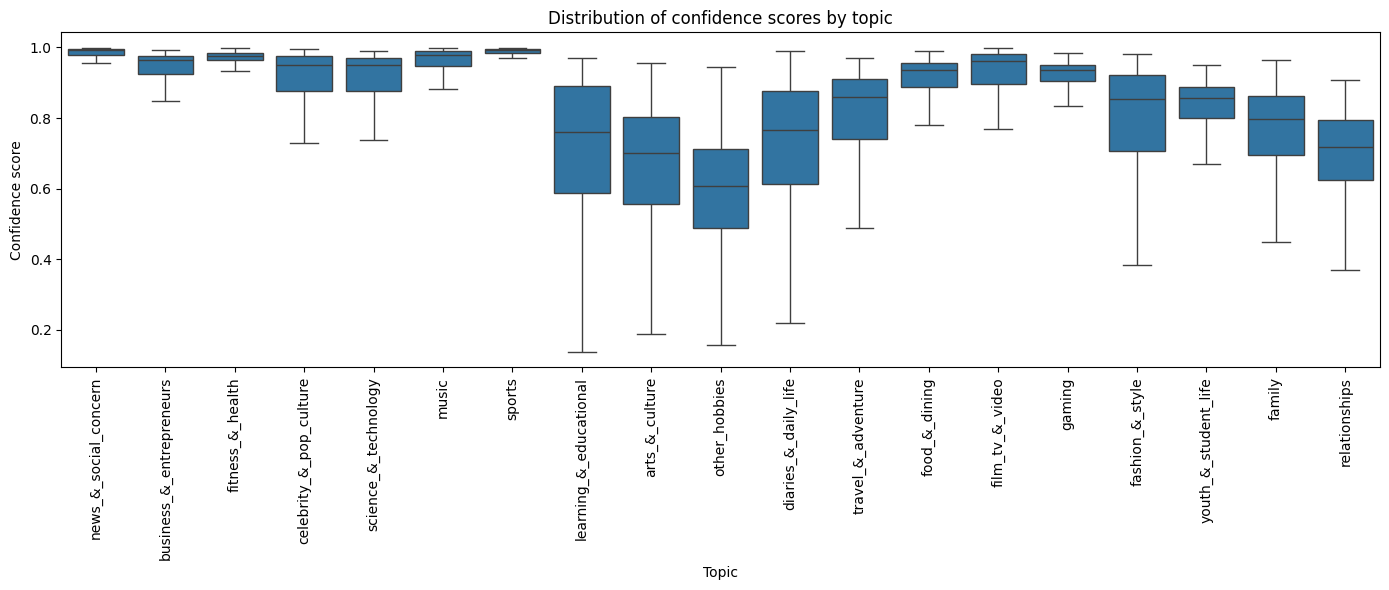

<Figure size 640x480 with 0 Axes>

In [7]:
plot_df = df.dropna(subset=["topic", "topic_conf"])

plt.figure(figsize=(14, 6))

sns.boxplot(
    data=plot_df,
    x="topic",
    y="topic_conf",
    showfliers=False
)

plt.xticks(rotation=90)
plt.xlabel("Topic")
plt.ylabel("Confidence score")
plt.title("Distribution of confidence scores by topic")
plt.tight_layout()
plt.show()

plt.savefig(os.path.join(IMG_DIR, "topic_confidence_boxplot.png"))

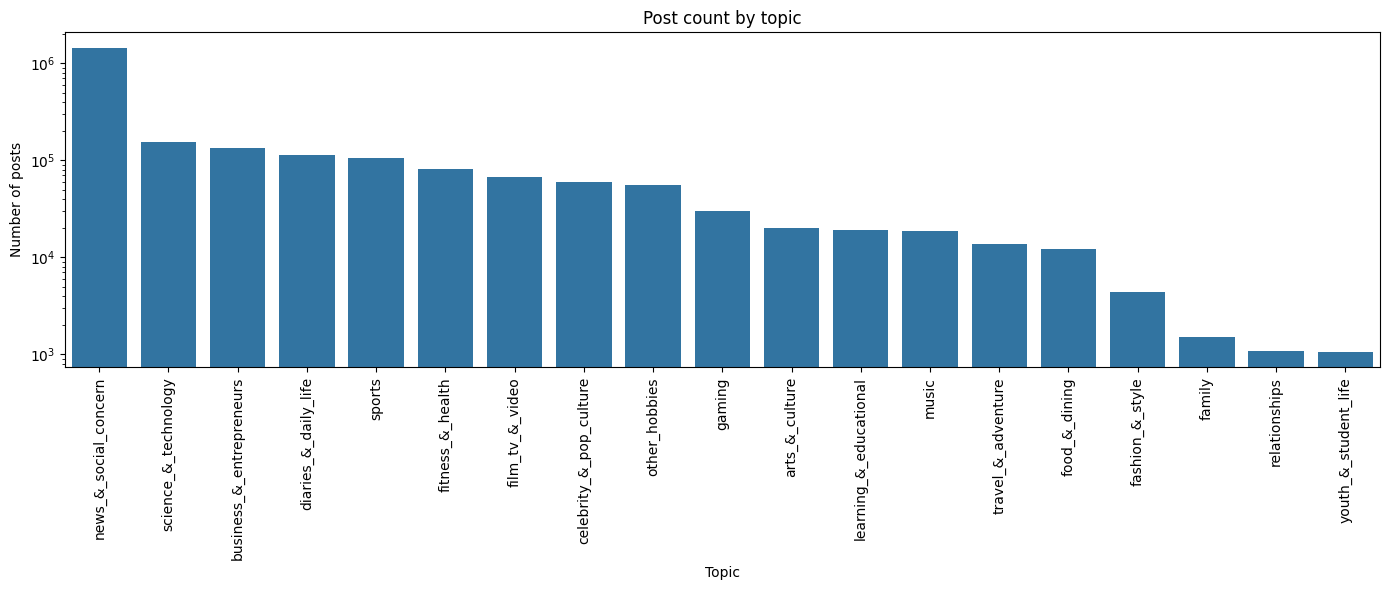

<Figure size 640x480 with 0 Axes>

In [8]:
plot_df = df.dropna(subset=["topic"])

plt.figure(figsize=(14, 6))

sns.countplot(
    data=plot_df,
    x="topic",
    order=plot_df["topic"].value_counts().index
)
plt.yscale("log")
plt.xticks(rotation=90)
plt.xlabel("Topic")
plt.ylabel("Number of posts")
plt.title("Post count by topic")
plt.tight_layout()
plt.show()

plt.savefig(os.path.join(IMG_DIR, "topic_count.png"))

### 4 Predict Political Topic with manifestoberta-xlm-roberta-56policy-topics-sentence-2024-1-1"

In [20]:
MODEL = "manifesto-project/manifestoberta-xlm-roberta-56policy-topics-sentence-2024-1-1"

tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-large")
model = AutoModelForSequenceClassification.from_pretrained(MODEL).to(device)
model.eval()

id2label = model.config.id2label

In [ ]:
@torch.no_grad()
def predict_manifestoberta(texts, batch_size=32, max_length=128):
    labels = []
    confs = []

    for i in tqdm(range(0, len(texts), batch_size), desc="policy batches"):
        batch = texts[i:i + batch_size]

        inputs = tokenizer(
            batch,
            return_tensors="pt",
            max_length=max_length,
            padding=True,
            truncation=True,
        )
        inputs = {k: v.to(device) for k, v in inputs.items()}

        logits = model(**inputs).logits
        probs = torch.softmax(logits, dim=1)

        top_probs, top_idx = torch.max(probs, dim=1)

        top_probs = top_probs.detach().cpu().tolist()
        top_idx = top_idx.detach().cpu().tolist()

        for p, idx in zip(top_probs, top_idx):
            labels.append(id2label[int(idx)])
            confs.append(float(p))

    return labels, confs

In [31]:
def label_policy_trunk(
    in_path: str,
    out_path: str,
    id_col: str = "noteId",
    text_col: str = "summary_en",
    topic_col: str = "topic",
    target_topic: str = "news_&_social_concern",
    label_col: str = "political_label",
    conf_col: str = "political_conf",
    chunksize: int = 50_000, 
    batch_size: int = 32,
    max_length: int = 128,
):
    os.makedirs(os.path.dirname(out_path), exist_ok=True)

    df = pd.read_parquet(in_path, engine="pyarrow")

    if label_col not in df.columns:
        df[label_col] = pd.NA
    if conf_col not in df.columns:
        df[conf_col] = np.nan

    mask = df[topic_col].astype(str).eq(target_topic)
    sub = df.loc[mask, [id_col, text_col]].copy()

    print("total rows:", len(df))
    print("target rows:", len(sub))

    if len(sub) == 0:
        df.to_parquet(out_path, engine="pyarrow", index=False)
        print("No target rows. saved:", out_path)
        return df

    dup = sub[id_col].duplicated().sum()
    if dup > 0:
        raise ValueError(
            f"{id_col} is not unique within target subset. duplicated ids: {dup}"
        )

    out_sub_chunks = []
    for start in tqdm(range(0, len(sub), chunksize), desc="policy chunks"):
        end = min(start + chunksize, len(sub))
        sub_chunk = sub.iloc[start:end].copy()

        texts = sub_chunk[text_col].fillna("").astype(str).tolist()
        labels, confs = predict_manifestoberta(
            texts, batch_size=batch_size, max_length=max_length
        )

        sub_chunk[label_col] = labels
        sub_chunk[conf_col] = confs
        out_sub_chunks.append(sub_chunk[[id_col, label_col, conf_col]])

    sub_labeled = pd.concat(out_sub_chunks, ignore_index=True)

    df2 = df.merge(sub_labeled, on=id_col, how="left", suffixes=("", "_new"))

    if f"{label_col}_new" in df2.columns:
        df2[label_col] = df2[f"{label_col}_new"].combine_first(df2[label_col])
        df2.drop(columns=[f"{label_col}_new"], inplace=True)

    if f"{conf_col}_new" in df2.columns:
        df2[conf_col] = df2[f"{conf_col}_new"].combine_first(df2[conf_col])
        df2.drop(columns=[f"{conf_col}_new"], inplace=True)

    df2.to_parquet(out_path, engine="pyarrow", index=False)
    print("saved:", out_path)

    wrote = int(df2[label_col].notna().sum())
    print("rows with non-null policy_label:", wrote)

    return df2


In [ ]:
IN_PATH = "outputs/notes_with_topics.parquet"
OUT_PATH = "outputs/notes_with_topics_plus_policy.parquet"

if os.path.exists(OUT_PATH):
    df = pd.read_parquet(OUT_PATH, engine="pyarrow")
else:
    label_policy_trunk(
        in_path=IN_PATH,
        out_path=OUT_PATH
    )
    df = pd.read_parquet(OUT_PATH, engine="pyarrow")

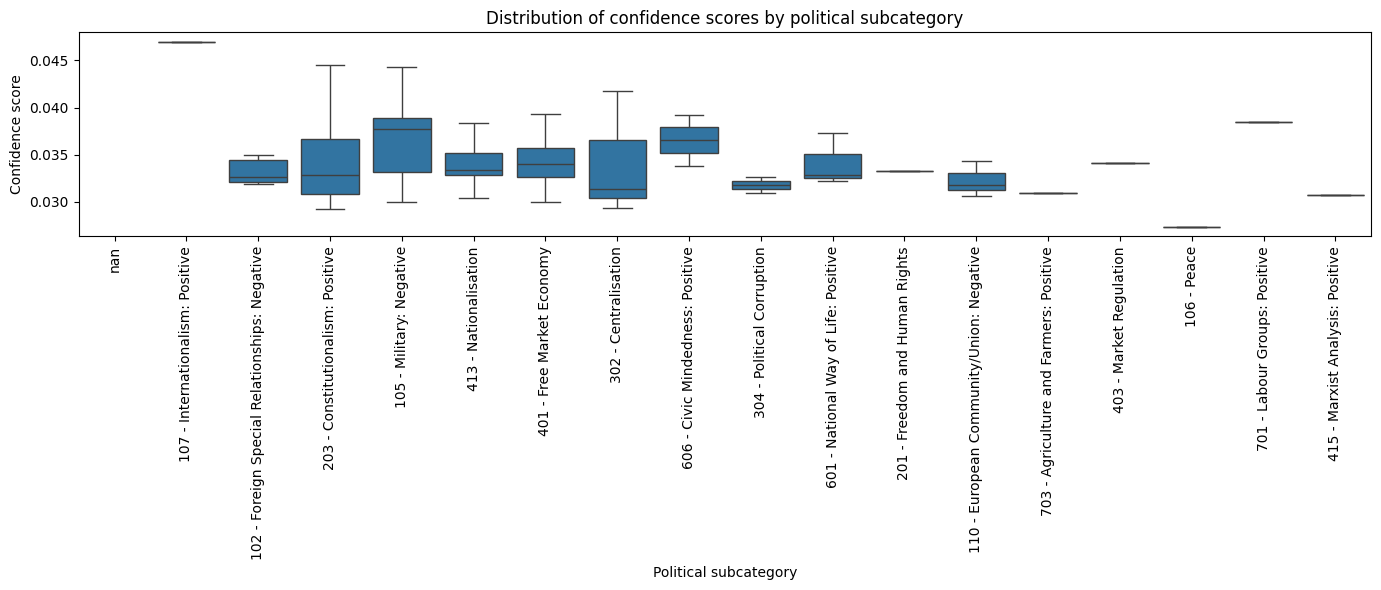

In [ ]:


plt.figure(figsize=(14, 6))

sns.boxplot(
    data=df,
    x="political_label",
    y="political_conf",
    showfliers=False
)

plt.xticks(rotation=90)
plt.xlabel("Political subcategory")
plt.ylabel("Confidence score")
plt.title("Distribution of confidence scores by political subcategory")
plt.tight_layout()
plt.show()
